### Synthetic Drift Detection ###

## Imports ## 

In [46]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import matplotlib.pyplot as plt

sys.path.append("../..")

from gemini.constants import *
from gemini.utils import *
from drift_detector.plotter import plot_drift_samples_pval, errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from drift_detector.utils import scale
from drift_detector.detector import Detector
from drift_detector.reductor import Reductor
from drift_detector.tester import TSTester, DCTester
from drift_detector.experimenter import Experimenter
from drift_detector.synthetic_applicator import SyntheticShiftApplicator, apply_predefined_shift

## Parameters ##

In [47]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
MODEL_PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/saved_models/random_lstm.pt"
TIMESTEPS = 6
AGGREGATION_TYPE = "time_flatten"
CONTEXT_TYPE="lstm"
REPRESENTATION="rf"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
OUTCOME = "mortality"

## Query Data

In [64]:
admin_data, x, y = get_gemini_data(PATH)

2022-10-05 10:34:02,486 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-05 10:34:02,780 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-05 10:34:02,921 INFO cyclops.feature_handler - Loading features from file...
2022-10-05 10:34:02,926 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-05 10:34:02,930 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-05 10:34:02,968 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-05 10:34:08,114 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-05 10:34:17,016 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Preprocess Data

In [65]:
# Get subset
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, "random", OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

if AGGREGATION_TYPE != "time":
    # Get labels
    y_tr = get_label(admin_data, X_tr, OUTCOME)
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)
    
# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

## Reductor

In [7]:
DR_TECHNIQUE = input("Select dimensionality reduction technique: ")

reductor = Reductor(
    dr_method = DR_TECHNIQUE,
    model_path = MODEL_PATH,
    var_ret = 0.8,
)

Select dimensionality reduction technique:  PCA


## Two Sample Tester

In [8]:
TS_TEST = input("Select test method: ")

tester = TSTester(
    tester_method=TS_TEST,
)

Select test method:  mmd


## Domain Classifier Tester

In [ ]:
DC_TEST = input("Select test method: ")

tester = DCTester(
    tester_method=DC_TEST,
)

## Detector 

In [9]:
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05,
)
detector.fit(X_tr_final)

## SyntheticShiftApplicator

In [10]:
shiftapplicator = SyntheticShiftApplicator(
    shift_type = "gn_shift",
) 

## Experimenter

In [11]:
experimenter_custom = Experimenter(
    detector = detector,
    shiftapplicator = shiftapplicator,
    admin_data = admin_data
)

## Run custom shift experiment

In [12]:
X_t_final_shifted = experimenter_custom.apply_synthetic_shift(
    X_t_final,
    shift_type="gn_shift",
    delta=0.01,
    noise_amt=0.01,
    clip=False
)

results = experimenter_custom.detect_shift_samples(
        X_t_final_shifted
    )

results

2022-10-05 09:45:33.455931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:45:33.567448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/opt/R/4.0.5/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-10-05 09:45:33.567512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu

{'samples': [10, 20, 50, 100, 200, 500, 1000],
 'mean_p_vals': array([0., 0., 0., 0., 0., 0., 0.]),
 'std_p_vals': array([0., 0., 0., 0., 0., 0., 0.]),
 'mean_dist': array([0.21925485, 0.17856405, 0.12100201, 0.10810322, 0.05805973,
        0.02112937, 0.01309993]),
 'std_dist': array([0.00000000e+00, 7.34329224e-06, 4.13252375e-06, 2.09788029e-06,
        1.20548828e-06, 3.28637332e-07, 1.10550147e-07])}

## Run predefined shift experiments ##

In [33]:
SHIFT = input("Select shift experiment: ")

if SHIFT =='ko_shift':
    shifts = ['ko_shift_0.1','ko_shift_0.5','ko_shift_1.0']
elif SHIFT == 'small_gn_shift':
    shifts = ['small_gn_shift_0.1','small_gn_shift_0.5','small_gn_shift_1.0']
elif SHIFT == 'medium_gn_shift':
    shifts = ['medium_gn_shift_0.1', 'medium_gn_shift_0.5','medium_gn_shift_1.0']
elif SHIFT == 'large_gn_shift':
    shifts = ['large_gn_shift_0.1','large_gn_shift_0.5','large_gn_shift_1.0']
elif SHIFT == 'mfa_shift':
    shifts = ['mfa_shift_0.25','mfa_shift_0.5','mfa_shift_0.75']
elif SHIFT == 'cp_shift':
    shifts = ['cp_shift_0.25','cp_shift_0.75']
elif SHIFT == 'small_bn_shift':
    shifts = ['small_bn_shift_0.1','small_bn_shift_0.5','small_bn_shift_1.0']
elif SHIFT == 'medium_bn_shift':
    shifts = ['medium_bn_shift_0.1','medium_bn_shift_0.5','medium_bn_shift_1.0']
elif SHIFT == 'large_bn_shift':
    shifts = ['large_bn_shift_0.1','large_bn_shift_0.5','large_bn_shift_1.0']

Select shift experiment:  small_bn_shift_0.1


In [60]:
experimenter_predefined = Experimenter(
    detector = detector,
    admin_data=admin_data
)

In [66]:
shift_results = {}
for si, shift in enumerate(shifts):
    X_t_final_shifted = X_t_final.copy()
    X_t_final_shifted, _ = apply_predefined_shift(shift, X=X_t_final_shifted,y=y_t)
    results = experimenter_predefined.detect_shift_samples(
        X_t_final_shifted
    )
    shift_results.update({shift:results})

In [67]:
X_t_final_shifted = X_t_final.copy()
X_t_final_shifted, _ = apply_predefined_shift(shift, X=X_t_final_shifted,y=y_t)

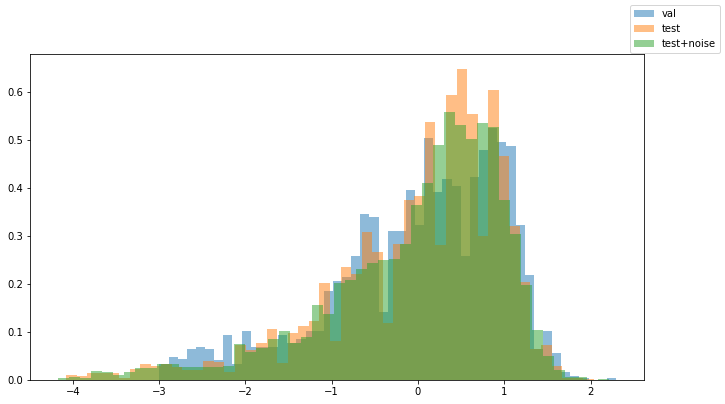

In [68]:
fig, ax = plt.subplots(figsize=(11, 6))
plt.hist(X_val_final[:,0], bins=50, alpha=0.5,label='val',density=True)
plt.hist(X_t_final[:,0], bins=50, alpha=0.5,label='test',density=True)
plt.hist(X_t_final_shifted[:,0], bins=50, alpha=0.5 , label='test+noise',density=True)
fig.legend(loc='upper right')
plt.show()

In [69]:
experimenter2.detect_shift_sample(
        X_t_final_shifted,
        sample=100
)

{'p_val': 0.0, 'distance': 0.002434671, 'shift_detected': True}

## Plot shift experiments

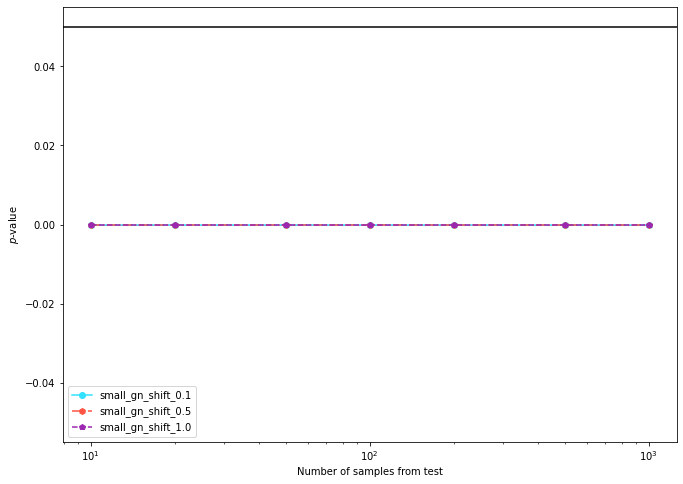

In [71]:
plot_drift_samples_pval(shift_results, 0.05)